### dset check
1. check pair-wise image and truth 
2. check the distribution of the dset. 

In [5]:
import numpy as np
from glob import glob
import rasterio as rio
import geopandas as gpd
import cartopy.crs as ccrs
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from utils.imgShow import imsShow
from shapely.geometry import Point
import cartopy.feature as cfeature
from utils.transform_xy import coor2coor


In [6]:
paths_truth = sorted(glob('data/dset/truth/*.tif'))
paths_scene = [path.replace('truth','scene') for path in paths_truth]
paths_dem = [path.replace('.tif', '_dem.tif').replace('truth','dem') 
                    for path in paths_truth]
names_satellite = [path_truth.split('/')[-1][0:2] 
                        for path_truth in paths_truth] 
print('Number of scenes:', len(paths_scene)) 
print('Satellite:', names_satellite[0]) 


Number of scenes: 65
Satellite: l5


1. Check the pair-wise sence and truth images


data/dset/scene/l8_scene_05.tif


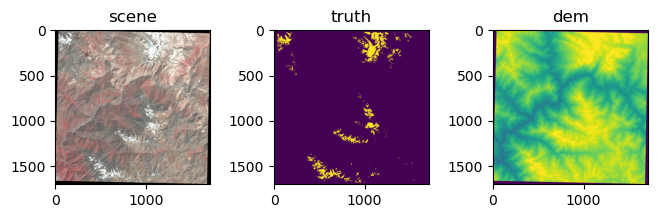

data/dset/scene/l8_scene_06.tif


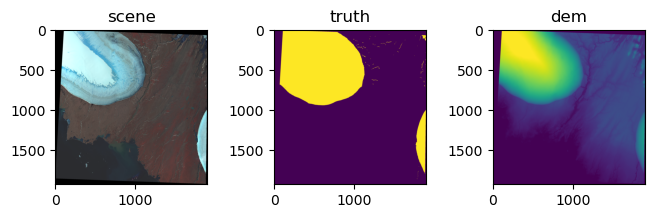

data/dset/scene/l8_scene_07.tif


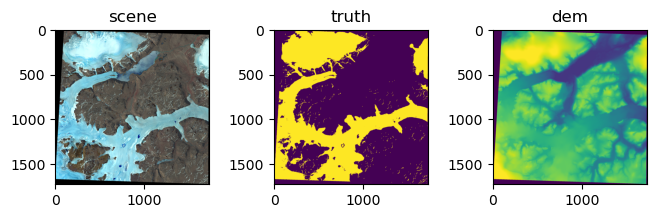

In [7]:
dset = list(zip(paths_scene, paths_truth, paths_dem))
for path_scene, path_truth, path_dem in dset[30:33]:
        print(path_scene)
        scene_rio = rio.open(path_scene)
        dem_rio = rio.open(path_dem)
        truth_rio = rio.open(path_truth)
        scene_truth_arr = [scene_rio.read([2,3,4]).transpose(1,2,0), 
                           truth_rio.read(1), dem_rio.read(1)]
        imsShow(img_list=scene_truth_arr,
                img_name_list=['scene', 'truth', 'dem'], figsize=(8,2))


1 statistics of the dataset   
2.1 pixel value of the satellite images

In [8]:
scenes_arr = {'l5': [], 'l7': [], 'l8': [],'l9': [], 's2': []}
for path_scene in paths_scene:
  sat = path_scene.split('/')[-1].split('_')[0]
  scenes_arr[sat].append(rio.open(path_scene).read().flatten())
scenes_arr = {key: np.concatenate(scenes_arr[key]) for key in scenes_arr} 


In [13]:
scenes_max = {key: np.max(scenes_arr[key]) for key in scenes_arr}
scenes_min = {key: np.min(scenes_arr[key]) for key in scenes_arr}
## remove head and tail values 
for key in scenes_arr:
    scenes_arr[key] = scenes_arr[key].astype(float)
    scenes_arr[key][scenes_arr[key] == scenes_max[key]] = np.nan
    scenes_arr[key][scenes_arr[key] == scenes_min[key]] = np.nan


In [14]:
scenes_max = {key: float(np.nanmax(scenes_arr[key])) for key in scenes_arr}
scenes_min = {key: float(np.nanmin(scenes_arr[key])) for key in scenes_arr}
print('Max value:', scenes_max)
print('Min value:', scenes_min)
scenes_99percentile = {key: float(np.nanpercentile(scenes_arr[key], 99)) for key in scenes_arr}
scenes_01percentile = {key: float(np.nanpercentile(scenes_arr[key], 1)) for key in scenes_arr} 
print('99 percentile:', scenes_99percentile)
print('01 percentile:', scenes_01percentile)


Max value: {'l5': 65454.0, 'l7': 56297.0, 'l8': 65439.0, 'l9': 65453.0, 's2': 19312.0}
Min value: {'l5': 4891.0, 'l7': 6719.0, 'l8': 1.0, 'l9': 1.0, 's2': 1.0}
99 percentile: {'l5': 41071.0, 'l7': 39080.0, 'l8': 44007.0, 'l9': 50541.0, 's2': 10736.0}
01 percentile: {'l5': 7165.0, 'l7': 7260.0, 'l8': 6329.0, 'l9': 6695.0, 's2': 1.0}


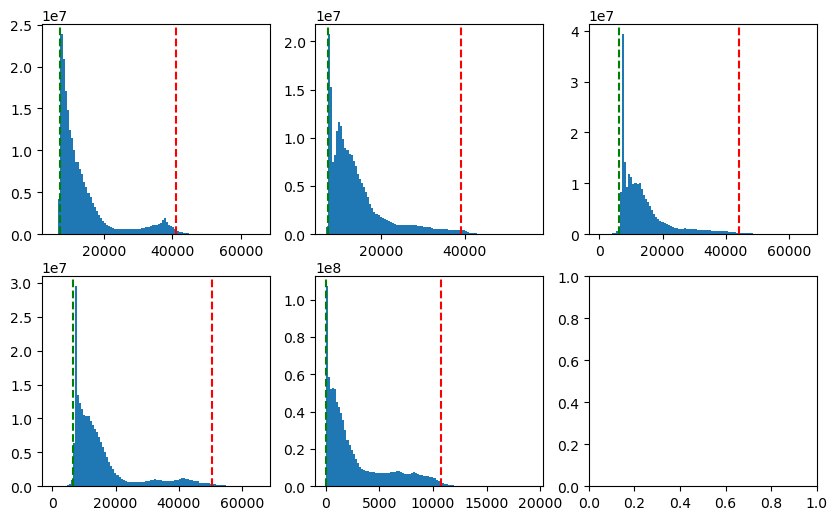

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(10,6))
keys = ['l5', 'l7', 'l8', 'l9', 's2']
for i in range(2):
    for j in range(3):
      key = keys[i*3 + j]
      ax[i, j].hist(scenes_arr[key], bins=100); 
      ax[i, j].axvline(x=scenes_99percentile[key], color='r', linestyle='--')
      ax[i, j].axvline(x=scenes_01percentile[key], color='g', linestyle='--')
      if i*3 + j == len(keys) - 1: break


#### 2.2 check glacier and non-glacier pixel samples.

In [8]:
truth_arr = {'l5': [], 'l7': [], 'l8': [],'l9': [], 's2': []}
for path_truth in paths_truth:
  sat = path_truth.split('/')[-1].split('_')[0]
  truth_arr[sat].append(rio.open(path_truth).read().flatten())
truth_arr = {key: np.concatenate(truth_arr[key]) for key in truth_arr} 


In [9]:
## statistics: (1) total pixels per satellite; 
## (2) glacier pixels vs. non-glacier pixels. 
total_pixel_sat = {key: truth_arr[key].shape[0] for key in truth_arr}
glacier_pixel_sat = {key: np.sum(truth_arr[key] == 1) for key in truth_arr}
non_glacier_pixel_sat = {key: np.sum(truth_arr[key] == 0) for key in truth_arr}
glacier_pixel_total = np.sum(list(glacier_pixel_sat.values()))
non_glacier_pixel_total = np.sum(list(non_glacier_pixel_sat.values()))
print('Total pixels per satellite:', total_pixel_sat)
print('Glacier pixels per satellite:', glacier_pixel_sat)
print('Non-glacier pixels per satellite:', non_glacier_pixel_sat)
print('Total glacier pixels:', glacier_pixel_total)
print('Total non-glacier pixels:', non_glacier_pixel_total)

Total pixels per satellite: {'l5': 38690504, 'l7': 39345489, 'l8': 40751989, 'l9': 38750046, 's2': 138704472}
Glacier pixels per satellite: {'l5': np.int64(8984782), 'l7': np.int64(8243567), 'l8': np.int64(7777412), 'l9': np.int64(9643526), 's2': np.int64(60060238)}
Non-glacier pixels per satellite: {'l5': np.int64(29705722), 'l7': np.int64(31101922), 'l8': np.int64(32974577), 'l9': np.int64(29106520), 's2': np.int64(78644234)}
Total glacier pixels: 94709525
Total non-glacier pixels: 201532975


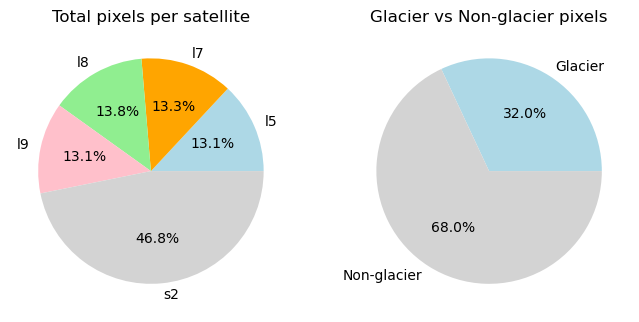

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
colors_sat = ['lightblue', 'orange', 'lightgreen', 'pink', 'lightgrey']
colors_gla_nongla = ['lightblue', 'lightgrey']
ax[0].pie(list(total_pixel_sat.values()), 
        labels=list(total_pixel_sat.keys()),
        autopct='%1.1f%%', 
        colors=colors_sat)
ax[0].set_title('Total pixels per satellite') 
ax[1].pie([glacier_pixel_total, non_glacier_pixel_total],
        labels=['Glacier', 'Non-glacier'],
        autopct='%1.1f%%',
        colors=colors_gla_nongla,
        startangle=0)
ax[1].set_title('Glacier vs Non-glacier pixels')
# fig.savefig('figs/dset_stats.png', dpi=300) 


#### 2. check the distribution of the dataset


In [11]:
### Get center coordinates (wgs84) of the landsat scenes
centroids_wgs84 = []
for path_truth in paths_truth:
    truth_rio = rio.open(path_truth)
    bounds_truth = truth_rio.bounds
    centroid_lon, centroid_lat = (bounds_truth.left + bounds_truth.right) / 2, \
                                 (bounds_truth.bottom + bounds_truth.top) / 2
    target_crs_wgs84 = CRS.from_epsg(4326)  
    if truth_rio.crs != target_crs_wgs84: ## crs are both formated by rio.crs.CRS
        centroid_lon, centroid_lat = coor2coor(
            crs_from = truth_rio.crs,          
            crs_to = target_crs_wgs84,      
            x = centroid_lon, 
            y = centroid_lat
            )       
    centroids_wgs84.append(Point([centroid_lon, centroid_lat]))
print('number of centroids:',len(centroids_wgs84))


number of centroids: 65


In [12]:
dset_gpd = gpd.GeoDataFrame({'satellite':names_satellite}, 
                            geometry=centroids_wgs84, crs=4326)
dset_gpd.head()


,satellite,geometry
0,l5,POINT (-73.26382 -46.03553)
1,l5,POINT (-26.08861 80.77256)
2,l5,POINT (-26.53769 81.76799)
3,l5,POINT (-18.2508 64.24576)
4,l5,POINT (-81.61367 74.72153)


In [13]:
sat_colors = {'l5': 'red', 
              'l7': 'green', 
              'l8': 'blue', 
              'l9': 'orange', 
              's2': 'purple'}


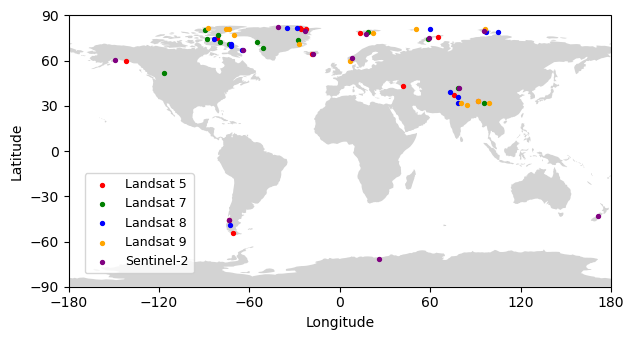

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-180, 180, -90, 90])
for sat, color in sat_colors.items():
    data_to_plot = dset_gpd[dset_gpd.satellite == sat]
    if not data_to_plot.empty:
        if sat == 's2': label_text = 'Sentinel-2'
        else: label_text = f'Landsat {sat[-1]}'           
        data_to_plot.plot(ax=ax,  marker='o', 
                            markersize=8, 
                            color=color, 
                            label=label_text,
                            aspect='equal'
                            )
ax.legend(loc=(0.03,0.05), fontsize=9)
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.tick_params(labelsize=10)
# fig.savefig('figs/dset_distribution.png', dpi=300)
